# VQ-VAE

In [44]:
from model import VQVAE

import tensorflow as tf
import keras as K
import numpy as np
import os

import matplotlib.pyplot as plt

### Data Preprocessing

In [45]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits_train = tf.cast(x_train, tf.float64) / 255.0
mnist_digits_train = np.expand_dims(mnist_digits_train, -1)
mnist_digits_test = tf.cast(x_test, tf.float64) / 255.0
mnist_digits_test = np.expand_dims(mnist_digits_test, -1)

train_variance = np.var(x_train / 255.0) # Normalizar 
print(train_variance)

0.09493041879725218


### Training the VAE

In [46]:
vqvae = VQVAE(image_size=28, channels=1, latent_dim=16, train_variance=train_variance, num_embeddings=128, beta=0.5)
vqvae.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))
callbacks = vqvae.get_callbacks(log_dir="logs", patience=10)
vqvae.fit(mnist_digits_train, epochs=50, batch_size=256, callbacks=callbacks)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.4278 - reconstruction_loss: 2.4265 - vqvae_loss: 0.0013
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.3883 - reconstruction_loss: 2.3846 - vqvae_loss: 0.0036
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.3137 - reconstruction_loss: 2.2850 - vqvae_loss: 0.0287
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.2357 - reconstruction_loss: 2.0920 - vqvae_loss: 0.1437
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.1875 - reconstruction_loss: 1.8411 - vqvae_loss: 0.3464
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.1117 - reconstruction_loss: 1.5931 - vqvae_loss: 0.5186
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.0674 - reconstruction_loss: 1.3983 - vqvae_loss: 0.6691
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.1124 - reconstruction_loss: 1.2697 - vqvae_loss: 0.8427
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/

In [47]:
for metric in vqvae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 5.066294193267822
reconstruction_loss: 0.7222742438316345
vq_loss: 4.344018459320068


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [48]:
# Save
os.makedirs("./weights", exist_ok=True)
vqvae.save("./weights/vqvae.keras")

/Users/roicort/GitHub/VAE-VQ-VAE/.venv/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [49]:
# Load
# vqvae = K.models.load_model("./weights/vqvae.keras") # WIP: Fix needed    

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


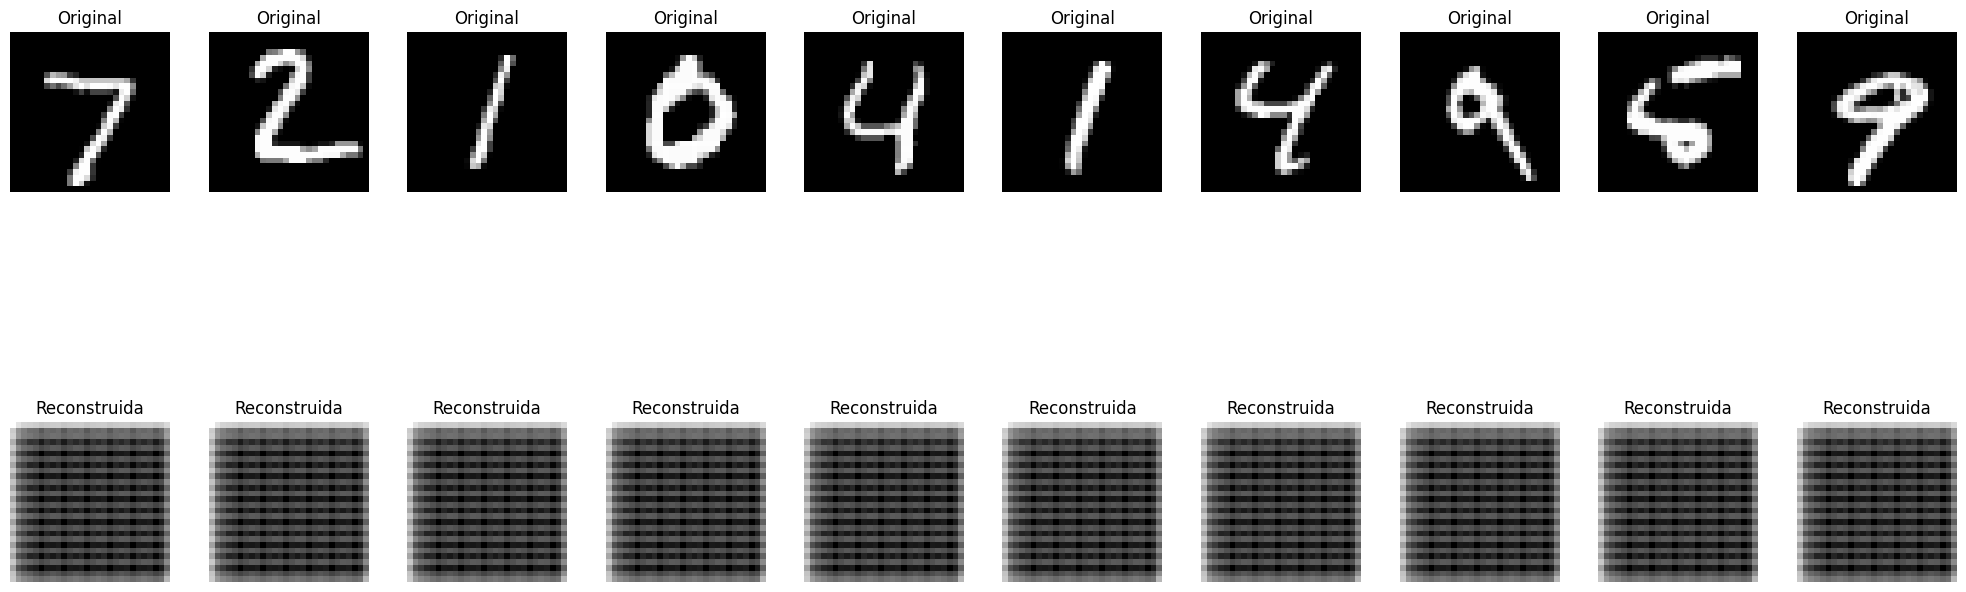

In [50]:
n = 10
example_images = mnist_digits_test[:n]
predictions = vqvae.vqvae.predict(example_images)

encondings = vqvae.encoder.predict(example_images)
vq_layer = vqvae.vqvae.get_layer("vector_quantizer")
quantized = vq_layer(encondings)
predictions = vqvae.decoder.predict(quantized)

plt.figure(figsize=(20, 6))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")
plt.tight_layout()
plt.show()

## CelebA Dataset

In [51]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [60]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float32) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [61]:
all_train_images = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

sum_ = 0.0
sum_sq = 0.0
n = 0

for img in all_train_images:
    img = tf.cast(img, tf.float32)
    sum_ += tf.reduce_sum(img)
    sum_sq += tf.reduce_sum(tf.square(img))
    n += tf.size(img).numpy()

mean = sum_ / n
train_variance = (sum_sq / n) - (mean ** 2)
print("Varianza de entrenamiento CelebA:", train_variance.numpy())

Varianza de entrenamiento CelebA: 0.08993445


In [62]:
vqvae2 = VQVAE(image_size=64, channels=3, latent_dim=256, train_variance=train_variance)

# Decoder adaptado para imágenes 64x64x3
latent_inputs = K.layers.Input(shape=vqvae2.encoder.output.shape[1:])
x = K.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(latent_inputs)  # 8x8 -> 16x16
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)              # 16x16 -> 32x32
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)              # 32x32 -> 64x64
decoder_outputs = K.layers.Conv2DTranspose(vqvae2.channels, 3, padding="same", activation="sigmoid")(x)
vqvae2.decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vqvae2.compile(optimizer=K.optimizers.Adam(learning_rate=1e-5))

In [65]:
callbacks2 = vqvae2.get_callbacks(log_dir="logs", patience=10)
vqvae2.fit(celeb_a_train_batched, epochs=50, callbacks=callbacks2)

Epoch 1/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 72s 113ms/step - loss: 1.5207 - reconstruction_loss: 0.6749 - vqvae_loss: 0.8458
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 73s 115ms/step - loss: 1.8834 - reconstruction_loss: 0.6619 - vqvae_loss: 1.2215
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - loss: 3.7855 - reconstruction_loss: 0.6836 - vqvae_loss: 3.1019
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - loss: 13.2627 - reconstruction_loss: 0.7047 - vqvae_loss: 12.5580
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 71s 112ms/step - loss: 47.6800 - reconstruction_loss: 0.7080 - vqvae_loss: 46.9720
Epoch 6/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 69s 108ms/step - loss: 134.0525 - reconstruction_loss: 0.7021 - vqvae_loss: 133.3505
Epoch 7/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - loss: 310.9094 - reconstruction_loss: 0.6943 - vqvae_loss: 310.2151
Epoch 8/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 71s 112ms/step - loss: 624.2211 - reconstruction_loss: 0.6860 - vqvae_loss: 623.5352
Epoch 9/50
636/6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


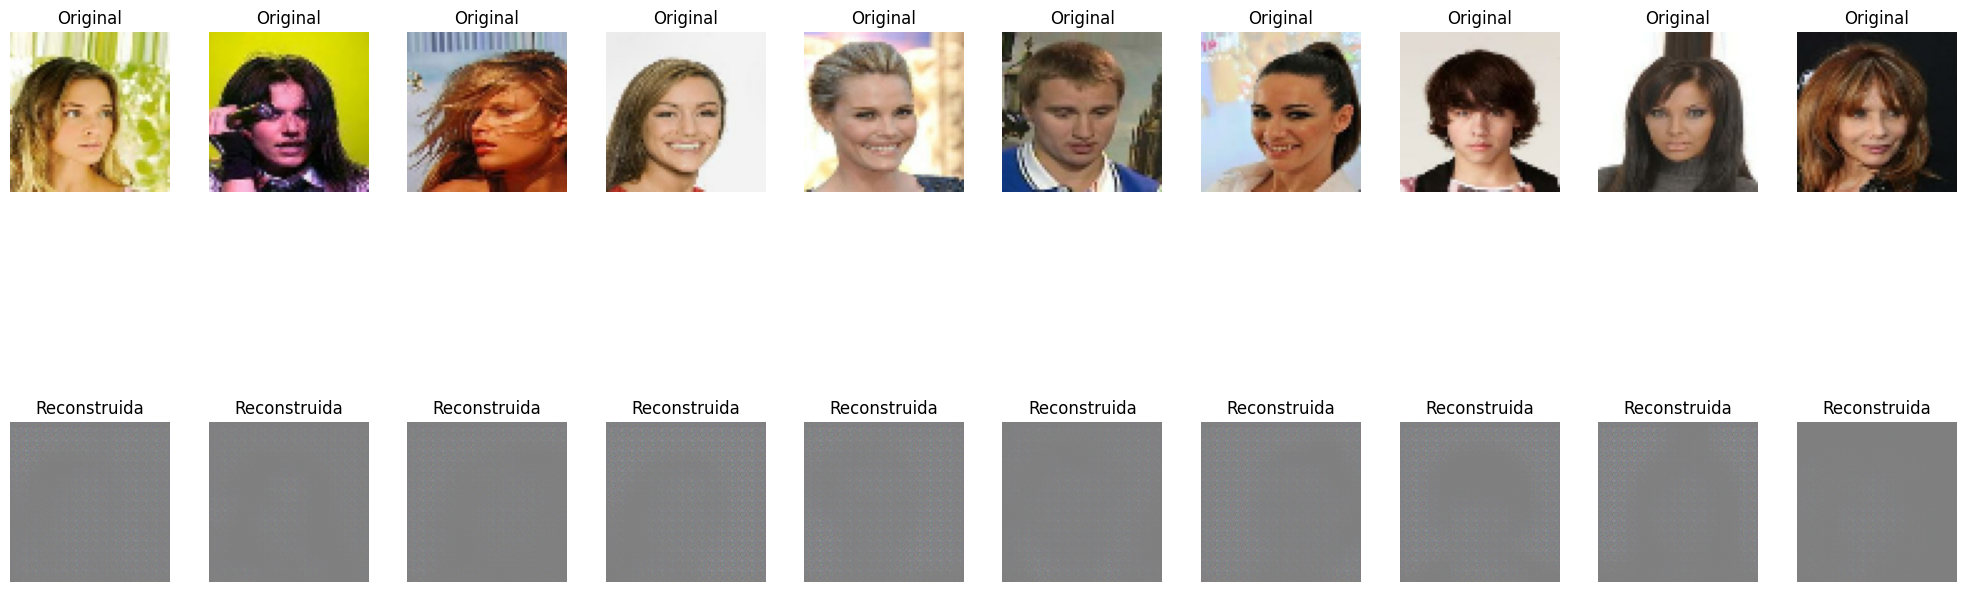

In [66]:
import matplotlib.pyplot as plt

n = 10
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)

# Obtener la representación latente z y las reconstrucciones
z = vqvae2.encoder.predict(images)
predictions = vqvae2.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].squeeze())
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze())
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
